In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
## LOAD DATA
df2 = pd.read_pickle('E:\Dropbox\PIBIC Ricado 2019\TCC Ricardo 2020-1\codigo\dados janeiro 2013\data_with_outliers_30_vales_picos_contextual.pkl')


In [4]:
def prepare_data(data, scaling = True,  differencing = False):
    ## PREPARANDO X, Y PARA PLOT 2D
    if differencing:
        P = np.array(data.diff()) 
        P[0]=0
    else:
        P = np.array(data) 

    F=np.concatenate((P, P), axis=0)
    G=np.reshape(F, (2, -1))
    X = np.transpose(G) # aqui temos as coordenadas Potencia x Potencia
    X = np.around(X, decimals=2) # 1 casa depois da virgula
    data = X[:,0]

    if scaling:
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        scaler = MinMaxScaler()
        data = scaler.fit_transform(X)[:,0]
    
    return data, scaler


def chunk_features(data, qtt=4):
    chunked = [data.values[i:i + 4] for i in range(0, len(data), 4)]
    return chunked

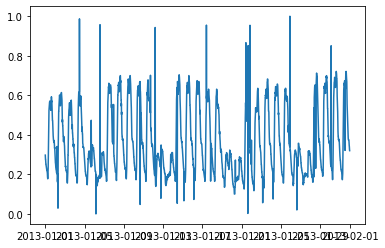

In [5]:
df2['Potencia_normalizada'], scaler = prepare_data(df2.Potencia, True, False)
plt.plot(df2.Potencia_normalizada)

### AQUI DIVIDIMOS OS DADOS PARA 4 ENTRADAS (Xn,Xn+1,Xn+2,Xn+3)
four_ents = chunk_features(df2.Potencia_normalizada, 4)

In [6]:
## SEPARANDO PARTE DOS DADOS PARA TREINAMENTO E VALIDAÇÃO
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(four_ents, test_size=0.3,random_state=42)

In [7]:
#%load_ext tensorboard
#import tensorflow as tf

def creating_autoencoder_model(input_dim=4, 
                               encoding_dim = 2, 
                               hidden_dim = 1, 
                               nb_epoch = 50, 
                               batch_size = 1, 
                               learning_rate = 0.1):

    from keras.models import Model, load_model
    from keras.layers import Input, Dense, Dropout, LSTM
    from keras import regularizers

    ## CRIANDO O MODELO
    input_layer = Input(shape=(input_dim, ))

    encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(hidden_dim, activation="relu")(encoder)
    decoder = Dense(hidden_dim, activation='relu')(encoder)
    decoder = Dense(encoding_dim, activation='relu')(encoder)
    decoder = Dense(input_dim, activation='tanh')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    return autoencoder


def training_model(autoencoder, nb_epoch, batch_size, X_train, X_test):
    
    from keras.callbacks import ModelCheckpoint, TensorBoard
    ## COMPILANDO O MODELO
    autoencoder.compile(optimizer='adam', 
                        loss='mse', 
                        metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                                   verbose=0,
                                   save_best_only=True)
    
    
    #!rm -rf ./logs/
    #log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    #tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


    history = autoencoder.fit(pd.DataFrame(X_train), pd.DataFrame(X_train),
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(pd.DataFrame(X_test), pd.DataFrame(X_test)),
                        verbose=1,
                        callbacks=[checkpointer]).history
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    
    return autoencoder

Using TensorFlow backend.
C:\Users\Ricardo Guerra\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ricardo Guerra\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ricardo Guerra\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Ricardo Guerra\anaconda3\lib\site-packages\t







Train on 520 samples, validate on 224 samples
Epoch 1/50
520/520 [==============================] - 2s 3ms/step - loss: 0.0743 - acc: 0.1731 - val_loss: 0.0338 - val_acc: 0.0714
Epoch 2/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0319 - acc: 0.1577 - val_loss: 0.0288 - val_acc: 0.0714
Epoch 3/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0303 - acc: 0.0712 - val_loss: 0.0288 - val_acc: 0.0714
Epoch 4/50
520/520 [==============================] - 2s 4ms/step - loss: 0.0303 - acc: 0.0596 - val_loss: 0.0289 - val_acc: 0.0714
Epoch 5/50
520/520 [==============================] - 2s 3ms/step - loss: 0.0303 - acc: 0.0769 - val_loss: 0.0289 - val_acc: 0.0714
Epoch 6/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0303 - acc: 0.0673 - val_loss: 0.0290 - val_acc: 0.1027
Epoch 7/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0302 - acc: 0.0962 - val_loss: 0.0288 - val_acc: 0.0714
Epoch 8/50
520/520 [====

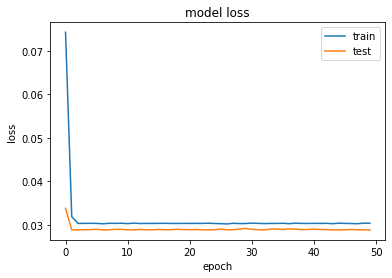

In [8]:
input_dim=4
encoding_dim = 2
hidden_dim = 2
nb_epoch = 50
batch_size = 1
learning_rate = 0.1

autoencoder = creating_autoencoder_model(input_dim, encoding_dim, 
                                       hidden_dim, 
                                       nb_epoch, 
                                       batch_size, 
                                       learning_rate)

autoencoder = training_model(autoencoder, nb_epoch, batch_size, X_train, X_test)

In [9]:
#%tensorboard --logdir logs/fit

In [10]:

df2 = pd.read_pickle('data_with_outliers.pkl')
P = np.array(df2.Potencia) #.diff()
P[0]=0
F=np.concatenate((P, P), axis=0)
G=np.reshape(F, (2, -1))
X = np.transpose(G) #aqui temos as coordenadas Potencia x Potencia
X = np.around(X, decimals=2) #1 casa depois da virgula
scaled_data = scaler.fit_transform(X)[:,0]
### AQUI DIVIDIMOS OS DADOS PARA 4 ENTRADAS (Xn,Xn+1,Xn+2,Xn+3)
four_ents = [scaled_data[i:i + 4] for i in range(0, len(scaled_data), 4)]


#predict it
predicted = autoencoder.predict(pd.DataFrame(four_ents))
#get the error term
menos = np.concatenate(predicted) - np.concatenate(four_ents)
mse = np.mean(np.power(pd.DataFrame(menos), 2), axis=1)
#now add them to our data frame
df2['MSE'] = mse.values

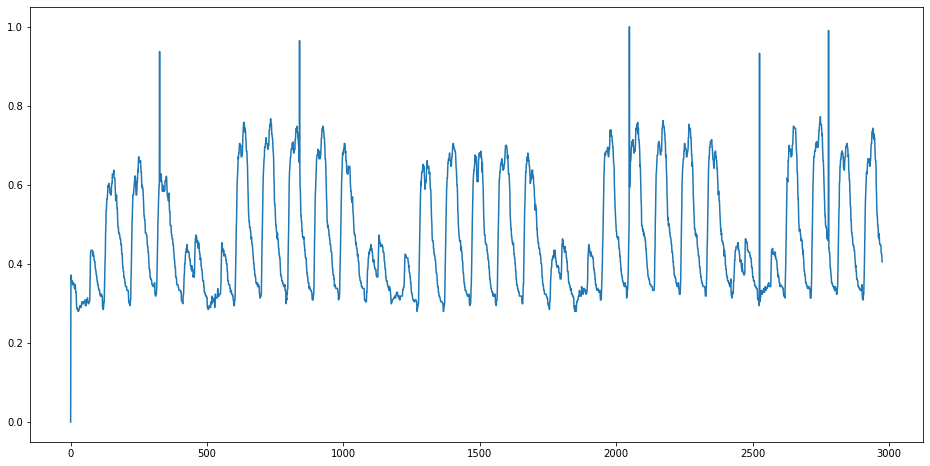

In [11]:
plt.figure(figsize=(16,8))
plt.plot(scaled_data)

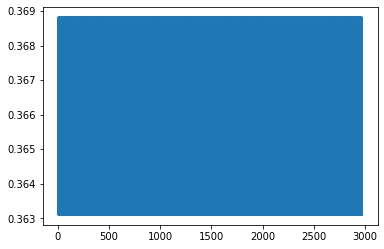

In [12]:
plt.plot(np.concatenate(predicted))

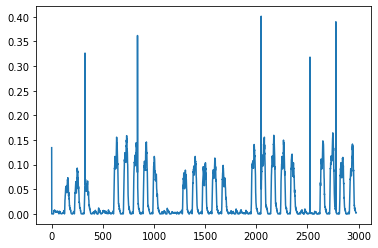

In [13]:
plt.plot(mse)

In [14]:
#### DESESCALA 
P=np.concatenate(predicted)
F=np.concatenate((P, P), axis=0)
G=np.reshape(F, (2, -1))
X = np.transpose(G)

df2['Potencia_desnormalizada'] = scaler.inverse_transform(X)[:,0]
#df2['Potencia_final'] = df2['Potencia_desnormalizada'].cumsum()



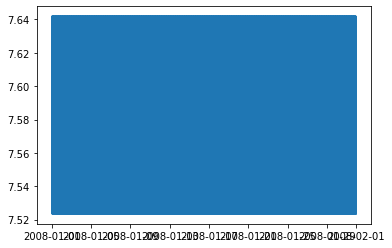

In [15]:
plt.plot(df2['Potencia_desnormalizada'])

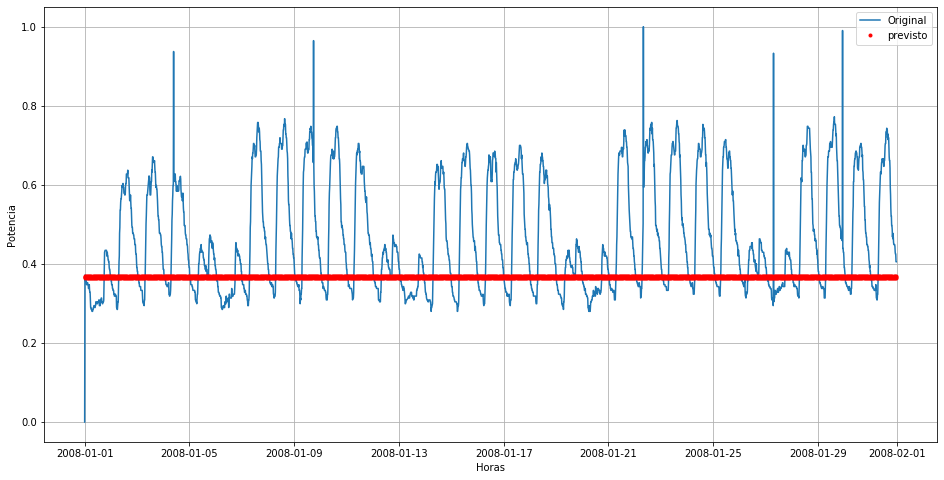

In [16]:
plt.figure(figsize=(16,8))
plt.plot (df2.index.values, np.concatenate(four_ents), df2.index.values, np.concatenate(predicted), 'r.')
plt.xlabel('Horas')
plt.ylabel('Potencia')
plt.legend(['Original','previsto','picos'])
plt.grid('on')

In [17]:
#mse_threshold = np.quantile(df2['MSE'], 0.9925)
#mse_threshold = 0.02

from scipy import stats
mse_threshold = stats.trim_mean(mse,0.01)*10
print(f'MSE 0.9999 threshhold:{mse_threshold}')

MSE 0.9999 threshhold:0.29697289606278937


In [18]:
df2['MSE_Outlier'] = 0
df2.loc[(df2['MSE'] > mse_threshold, 'MSE_Outlier')] = 1

In [19]:
print(f"Num of MSE outlier:{df2['MSE_Outlier'].sum()}")

Num of MSE outlier:5


In [20]:
outliers = df2[df2.MSE_Outlier==1]

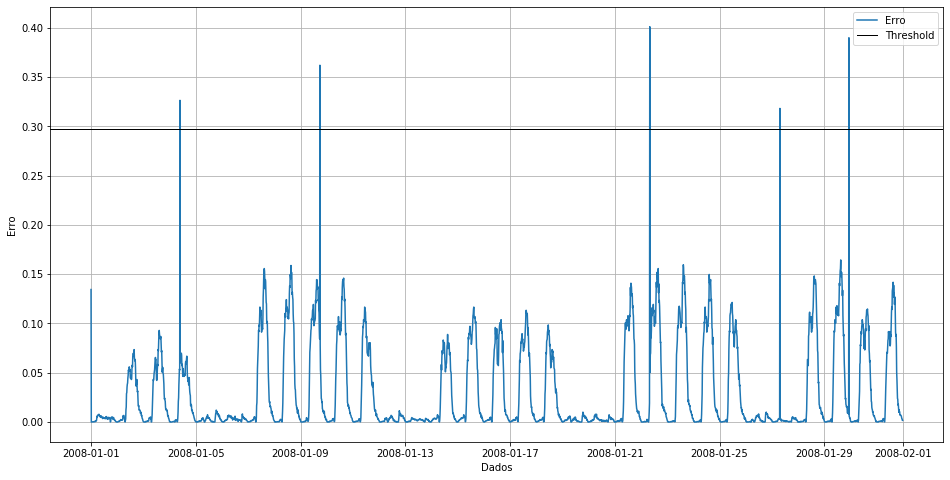

In [21]:
plt.figure(figsize=(16,8))
plt.plot (df2.index.values, df2.MSE)
plt.axhline(y=mse_threshold,linewidth=1, color='k')
plt.xlabel('Dados')
plt.ylabel('Erro')
plt.legend(['Erro','Threshold','picos'])
plt.grid('on')

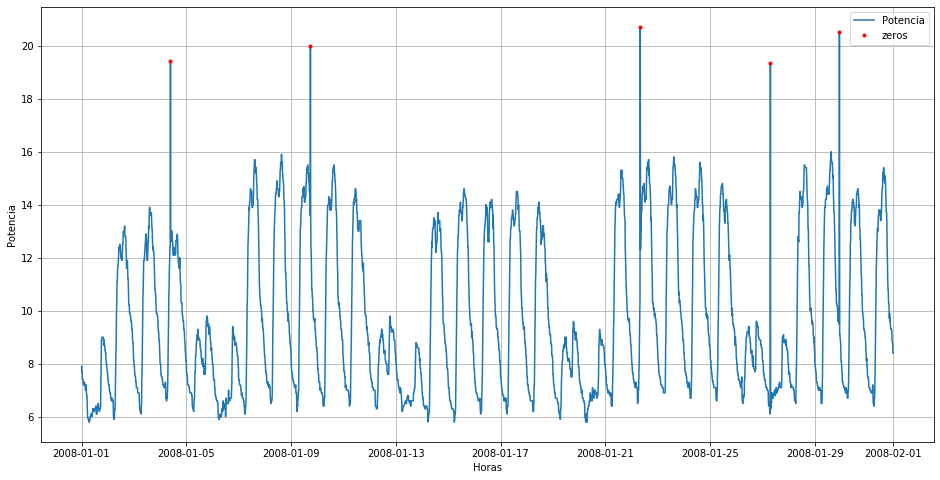

In [22]:
plt.figure(figsize=(16,8))
plt.plot (df2.index.values, df2.Potencia,outliers.index.values, outliers.Potencia,'r.')
plt.xlabel('Horas')
plt.ylabel('Potencia')
plt.legend(['Potencia','zeros','picos'])
plt.grid('on')